# 0.0 Imports

In [143]:
pip install sklearn

     |████████████████████████████████| 26.7 MB 5.1 MB/s eta 0:00:011
     |████████████████████████████████| 306 kB 7.2 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=fff511d99a7a3145906d02efe98034e2a17ff62f5200ab669361fb4de85b8281
  Stored in directory: /home/alex/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [147]:
import math
import datetime
import inflection

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as ss
from tabulate import tabulate
from matplotlib import gridspec
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler

## 0.1 Helper Functions

In [133]:
#V de Cramer
def cramer_v(x, y):
    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1))) 


plt.rcParams['figure.figsize'] = (18,10)
plt.style.use( 'bmh' )
plt.rcParams['font.size'] = 15

## 0.2 Loading Data

In [ ]:
df_sales_raw = pd.read_csv( 'datasets/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'datasets/store.csv', low_memory=False )
                           
#merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos Dados

## 1.1 Rename Columns

In [ ]:
df1 = df_raw.copy()

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimension

In [ ]:
print(f'Number of Rows{df1.shape[0]}')
print(f'Number of Cols{df1.shape[1]}')

## 1.3 Data Types

In [ ]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

## 1.4 Check NA

In [ ]:
df1.isna().sum()

## 1.5 Fillout NA

In [ ]:
df1['competition_distance'].max()

In [ ]:
# competition_distance    
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

# competition_open_since_year    
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

# promo2_since_week              
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

# promo2_since_year              
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

# promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

df1.isna().sum()

## 1.6 Change Types

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

df1.dtypes

In [ ]:
#df1.to_csv('df1.csv', index_label=False )

## 1.7 Descriptive Statistical

In [3]:
df2 = pd.read_csv( 'df1.csv', low_memory=False )

In [4]:
num_attributes = df2.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df2.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [5]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

/home/alex/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

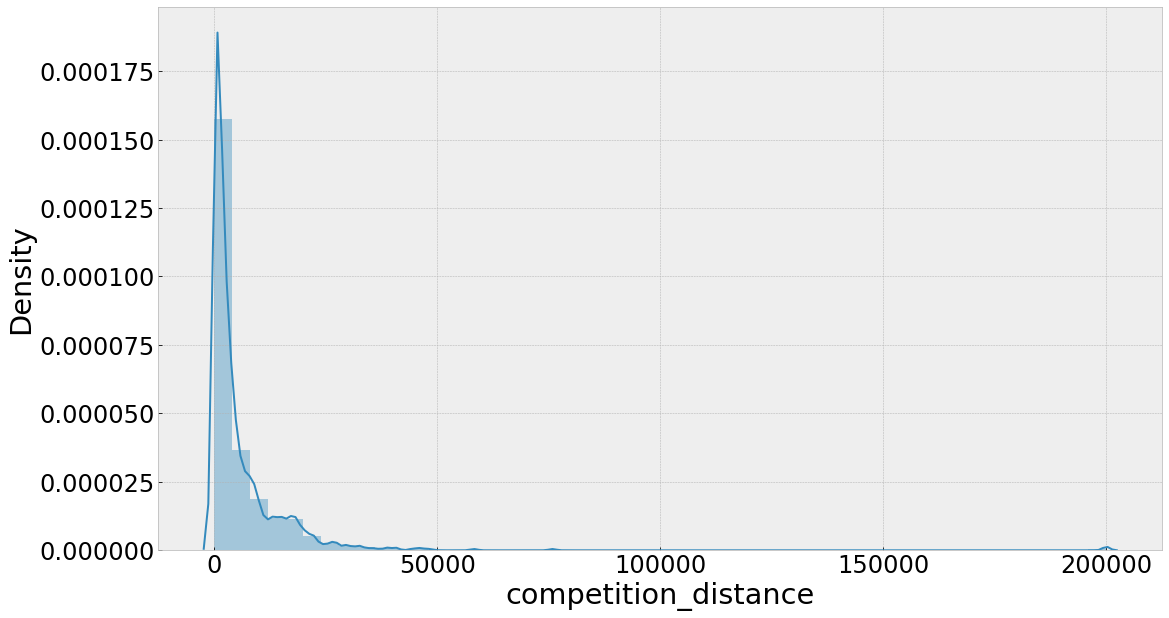

In [6]:
sns.distplot( df2['competition_distance'] )

### 1.7.2 Categorical Attributes

In [7]:
cat_attributes.apply( lambda x: x.unique().shape[0])

date              942
state_holiday       4
store_type          4
assortment          3
promo_interval      4
month_map          12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

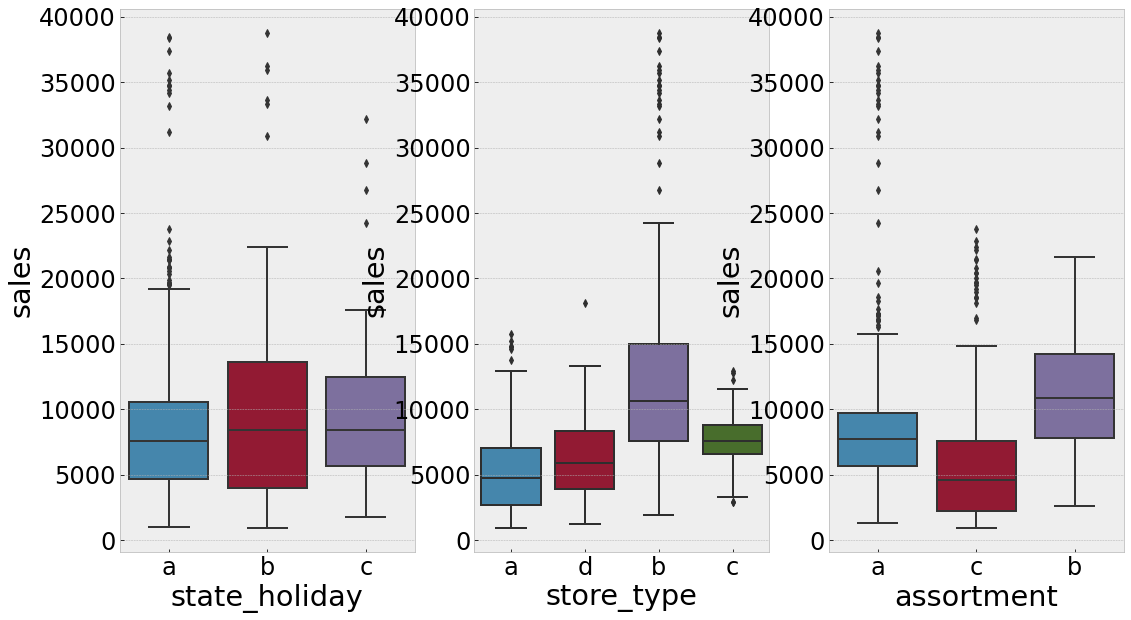

In [8]:
aux1 = df2[(df2['state_holiday'] !='0') & (df2['sales']>0)]

plt.subplot( 1, 3, 1)
sns.boxplot( x= 'state_holiday', y= 'sales', data=aux1)

plt.subplot( 1, 3, 2)
sns.boxplot( x= 'store_type', y= 'sales', data=aux1)

plt.subplot( 1, 3, 3)
sns.boxplot( x= 'assortment', y= 'sales', data=aux1)

# 2.0 Feature Engineering

## 2.1 Mapa Mental de Hipóteses

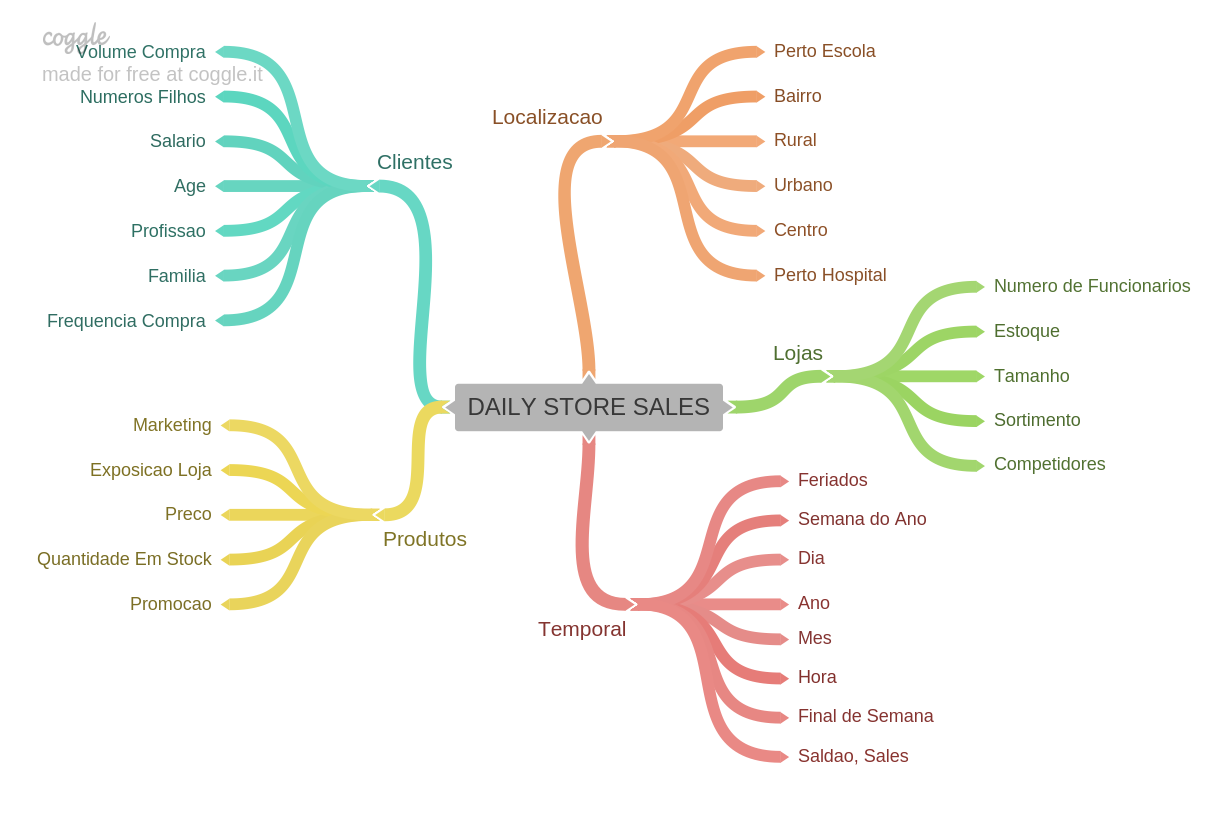

In [9]:
Image( 'img/MindMapHypothesis.png' )

## 2.2 Criação da Hipóteses

### 2.2.1 Hipóteses Loja

    -1 Lojas com maior quadro de funcionários deveriam vender mais
    
    -2 Lojas com maior estoque deveriam vender mais
    
    -3 Lojas com maior porte deveriam vender mais
    
    -4 Lojas com maior sortimento deveriam vender mais
    
    -5 Lojas com competidores mais próximos deveriam vender menos
    
    -6 Lojas com competidores à mais tempo deveriam vender mais

### 2.2.1 Hipóteses Produto

    -1 Lojas que investem mais em marketing deveriam vender mais
    
    -2 Lojas que expoe mais os produtos nas vitrines deveriam vender mais
    
    -3 Lojas que tem preços menores nos produtos deveriam vender mais
    
    -4 Lojas que possuem preços menores por mais tempo deveriam vender mais 
    
    -5 Lojas com descontos maiores deveriam vender mais
    
    -6 Lojas com promoções ativas por mais tempo deveriam vender mais
    
    -7 Lojas com mais dias de promoção deveriam vender mais
    
    -8 Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.1 Hipóteses Tempo

    -1 Lojas abertas durante o feriado de natal deveriam vender mais
    
    -2 Lojas deveriam vender mais ao longo dos anos
    
    -3 Lojas deveriam vender mais no segundo semestre do ano
    
    -4 Lojas deveriam vender mais depois do dia 10 do mês
    
    -5 Lojas deveriam vender menos aos finais de semana
    
    -6 Lojas deveriam vender menos durante os feriados escolares

## 2.3 Lista Final de Hipótesis

    -1 Lojas com maior sortimento deveriam vender mais
     
    -2 Lojas com competidores mais próximos deveriam vender menos
    
    -3 Lojas com competidores à mais tempo deveriam vender mais
     
    -4 Lojas com promoções ativas por mais tempo deveriam vender mais

    -5 Lojas com mais dias de promoção deveriam vender mais

    -6 Lojas com mais promoções consecutivas deveriam vender mais
      
    -7 Lojas abertas durante o feriado de natal deveriam vender mais
   
    -8 Lojas deveriam vender mais ao longo dos anos
    
    -9 Lojas deveriam vender mais no segundo semestre do ano
    
    -10 Lojas deveriam vender mais depois do dia 10 do mês
    
    -11 Lojas deveriam vender menos aos finais de semana
    
    -12 Lojas deveriam vender menos durante os feriados escolares    

## 2.2 Criação da Hipóteses

In [10]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [14]:
df2['date'] = pd.to_datetime( df2['date'])
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_since_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

#assortment / a=basic, b=extra, c=extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday / a=public holiday, b=easter holiday, c=christmas
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x =='c' else 'regular_day')


/tmp/ipykernel_14848/1728051345.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [16]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,year,month,day,week_of_year,year_week,competition_since,competition_since_month,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,2015,7,31,31,2015-30,2008-09-01,84,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,2015,7,31,31,2015-30,2007-11-01,94,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,2015,7,31,31,2015-30,2006-12-01,105,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,2015,7,31,31,2015-30,2009-09-01,71,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,2015,7,31,31,2015-30,2015-04-01,4,4,2015-07-27,0


In [17]:
df2.to_csv('df2.csv', index_label=False)

# 3.0 Filtragem de Variáveis

In [18]:
df3 = pd.read_csv( 'df2.csv', low_memory=False )

## 3.1 Filtragem das Linhas

In [19]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [20]:
df3 = df3.drop( columns = ['customers', 'open', 'promo_interval', 'month_map'] )

# 4.0 Análise Exploratória dos Dados

## 4.1 Análise Univariada

### 4.1.1 Response Variable

/home/alex/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

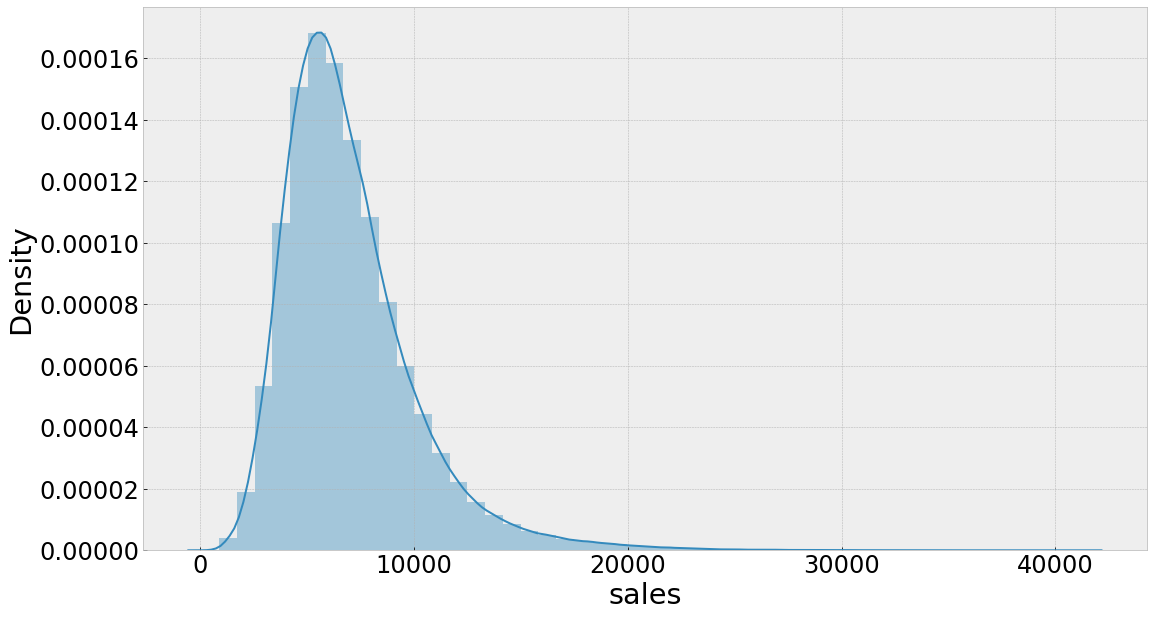

In [21]:
sns.distplot(df3['sales'])

### 4.1.2 Numerical Variable

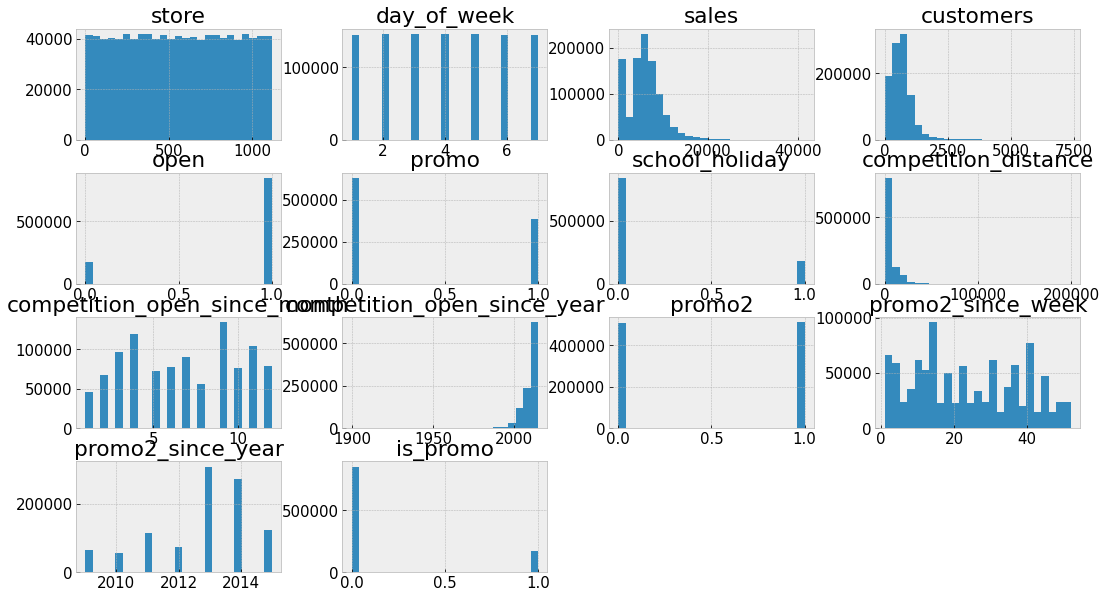

In [42]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [24]:
cat_attributes.head()

,date,state_holiday,store_type,assortment,promo_interval,month_map
0,2015-07-31,0,c,a,0,Jul
1,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,2015-07-31,0,c,c,0,Jul
4,2015-07-31,0,a,a,0,Jul


/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

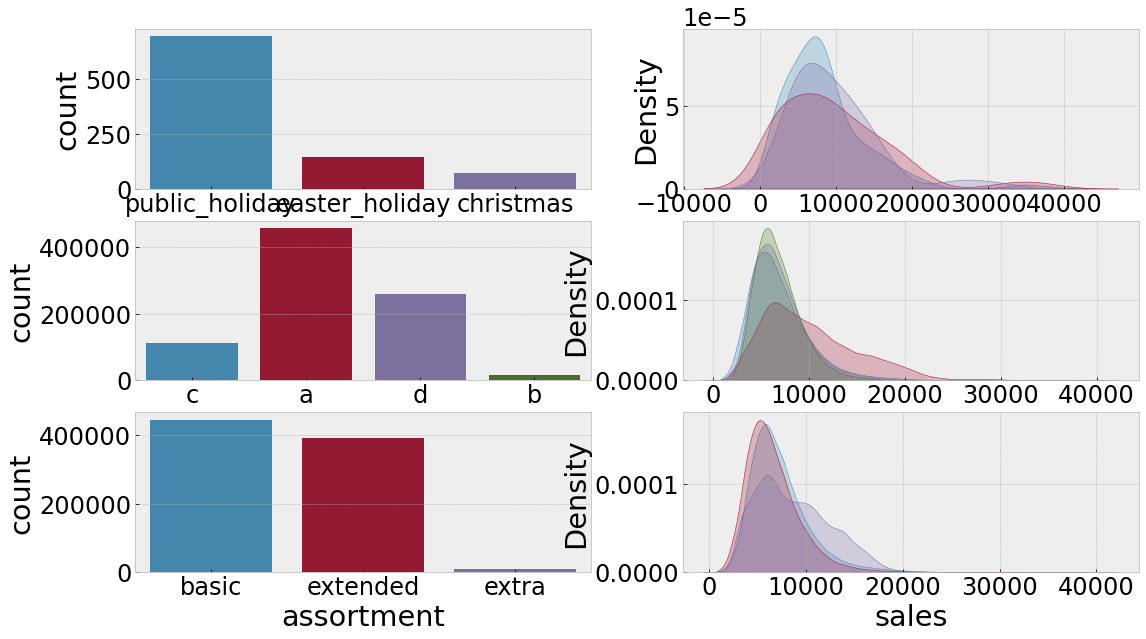

In [25]:
# state holiday
plt.subplot(3,2,1)
a = df3[df3['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df3[df3['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df3[df3['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df3[df3['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)

# store type
plt.subplot(3,2,3)
sns.countplot(df3['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df3[df3['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df3[df3['store_type'] == 'd']['sales'], label = 'd', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df3['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df3[df3['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df3[df3['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df3[df3['assortment'] == 'extra']['sales'], label = 'extra', shade=True)



## 4.2 Análise Bivariada

### H1.Lojas com maior sortimento deveriam vender mais
**Falsa** Lojas com maior sortimento na verdade vendem menos

<AxesSubplot:xlabel='year_week'>

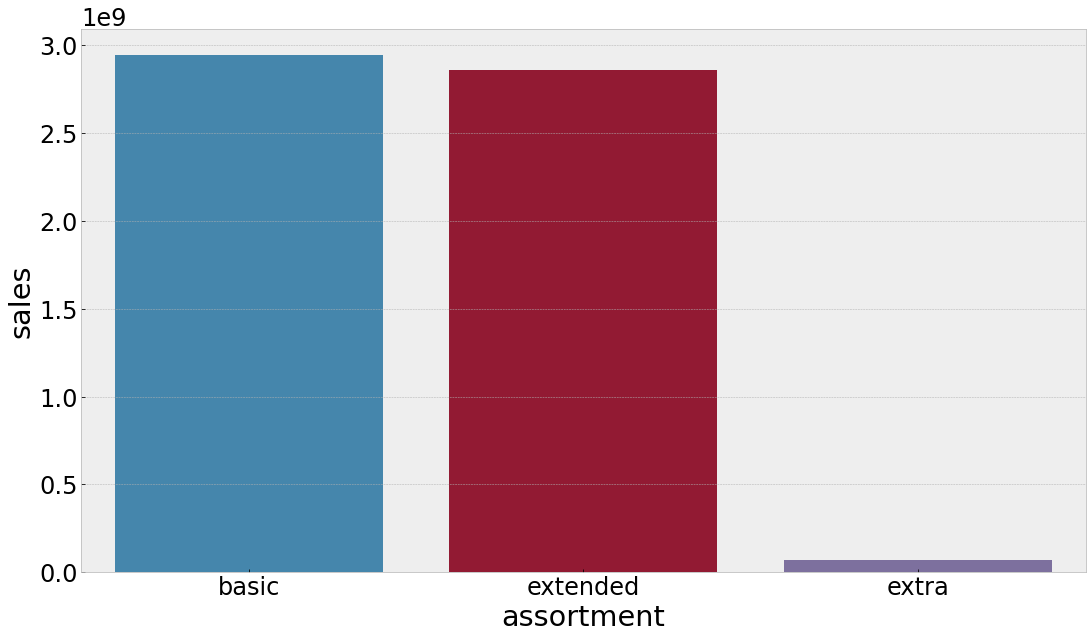

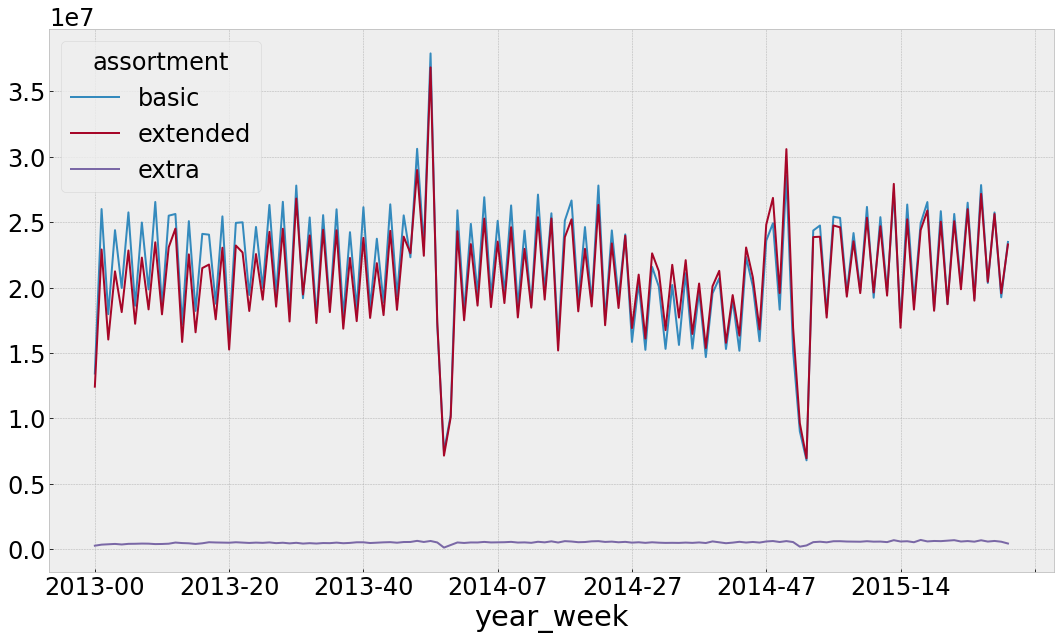

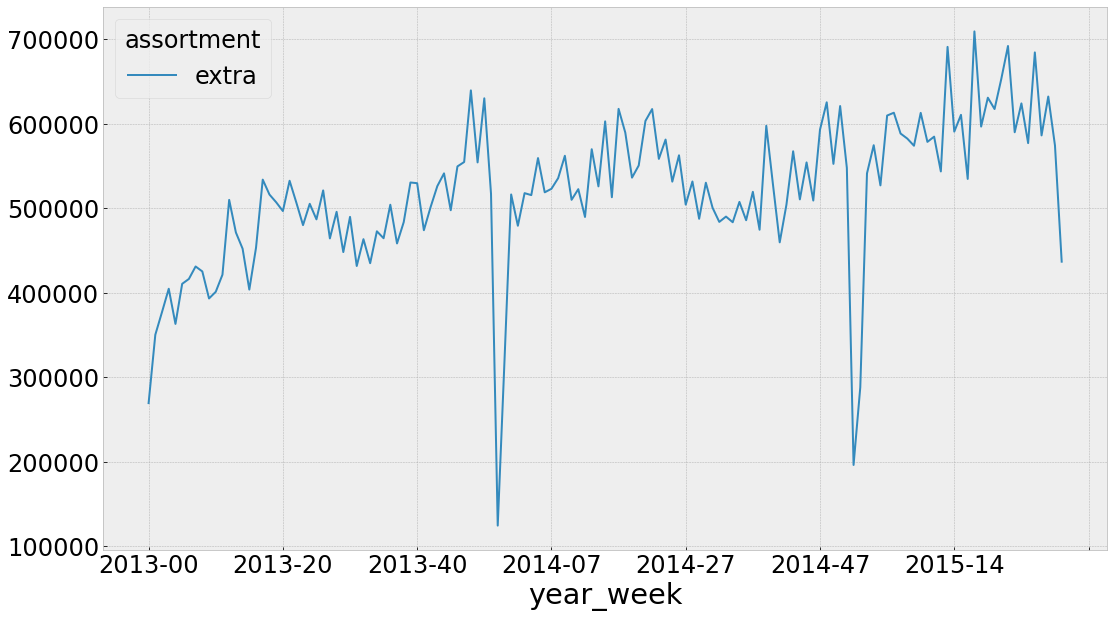

In [26]:
aux1 = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data = aux1);

aux2 = df3[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week',columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week',columns='assortment', values='sales').plot()

### H2.Lojas com competidores mais próximos deveriam vender menos
**Falsa** Lojas com competidores mais próximos vendem mais

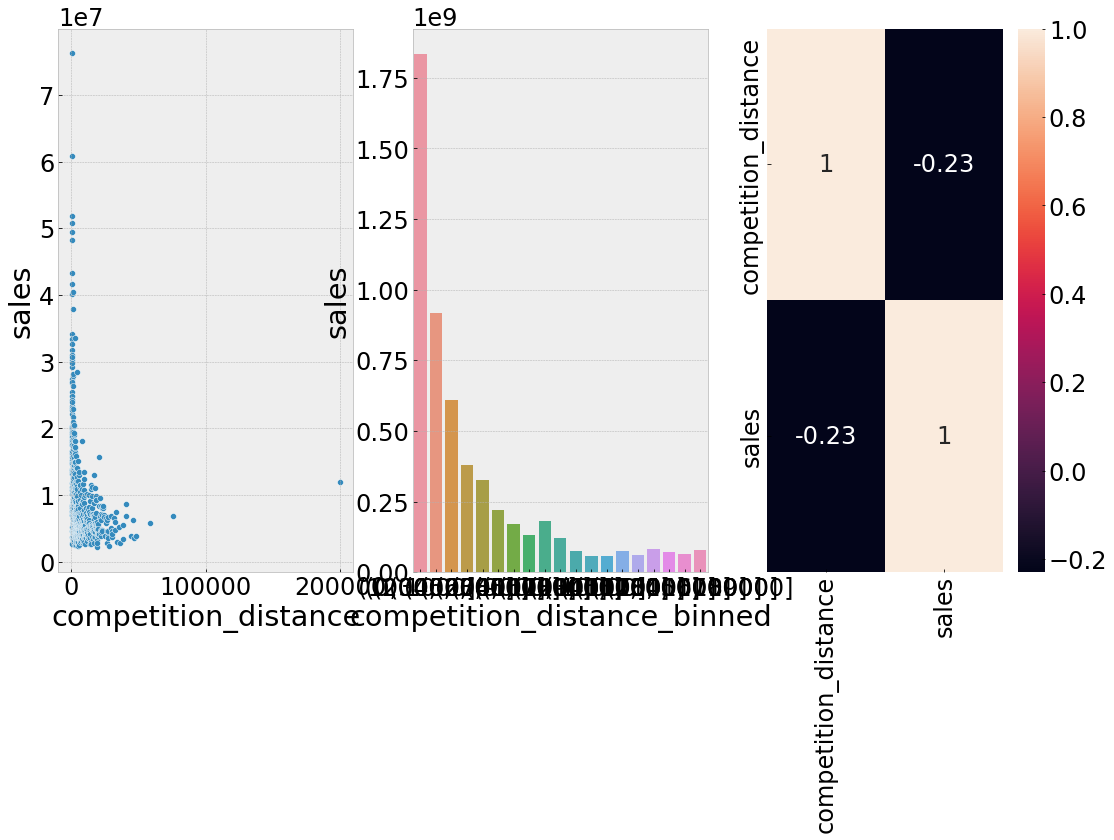

In [27]:
aux1 = df3[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x= 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### H3.Lojas com competidores à mais tempo deveriam vender mais
**Falsa** Lojas com competidores a mais tempo vendem menos

<AxesSubplot:>

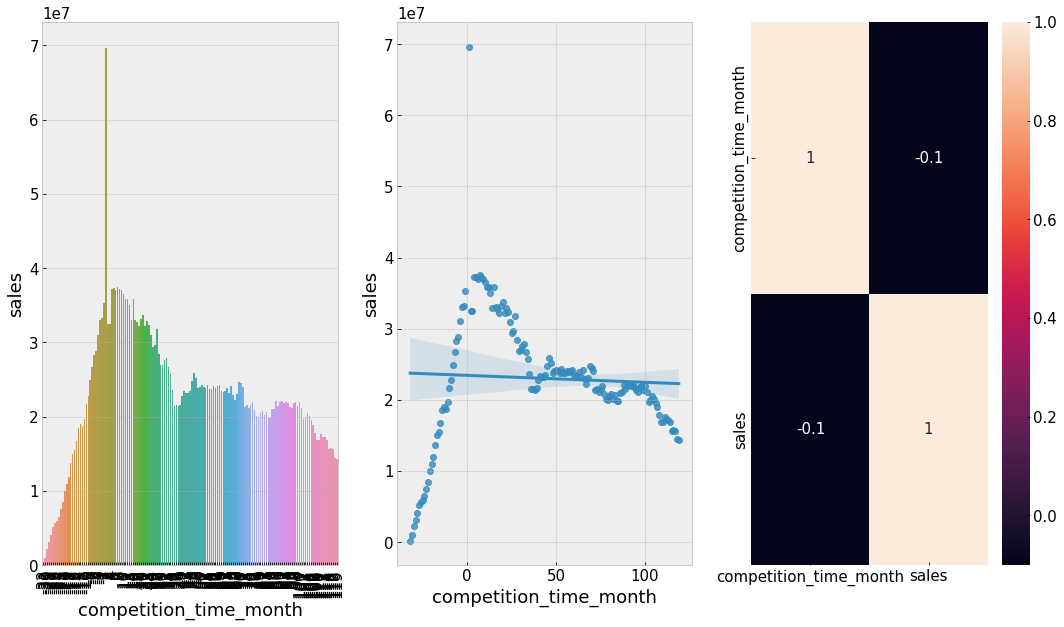

In [41]:
plt.subplot(1, 3, 1)
aux1 = df3[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1 [( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] !=0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

### H4.Lojas com promoções ativas por mais tempo deveriam vender mais
**Falsa** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo tempo de promoção

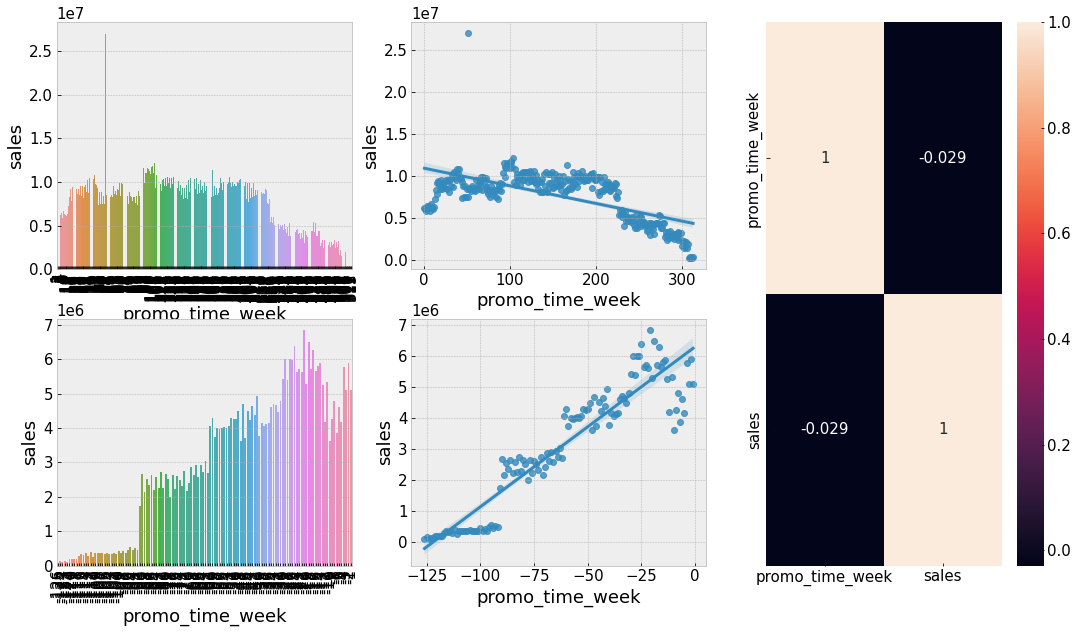

In [75]:
aux1 = df3[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90 );

plt.subplot( grid[0, 1] )
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=90 );

plt.subplot( grid[1, 1] )
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot( grid[:, 2] )
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### <s> H5.Lojas com mais dias de promoção deveriam vender mais </s>

### H6.Lojas com mais promoções consecutivas deveriam vender mais
**Falsa** Lojas com mais promoções consecutivas vendem menos

In [59]:
df3[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


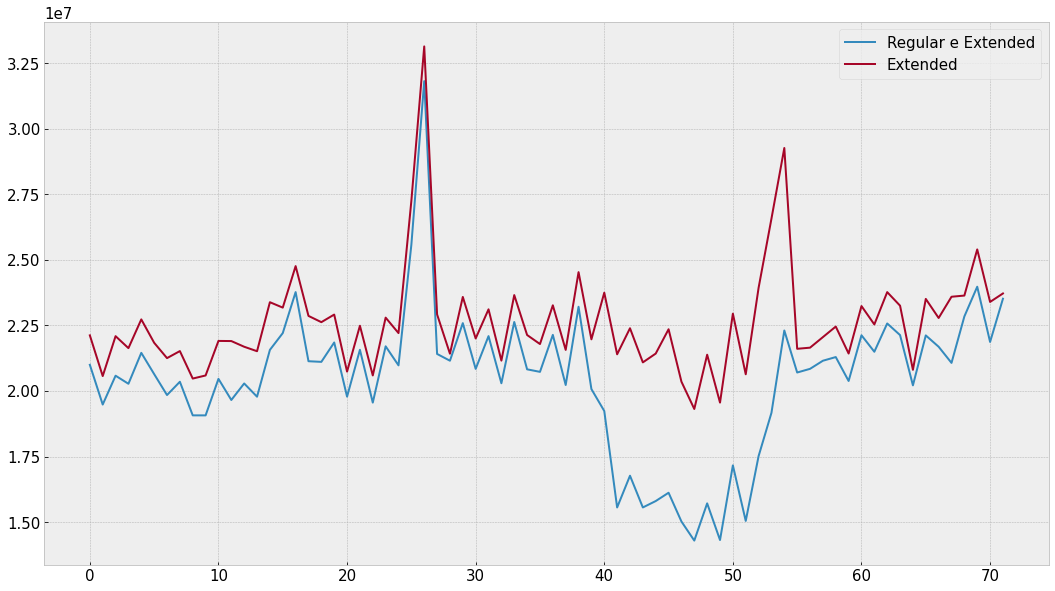

In [64]:
aux1 = df3[(df3['promo'] == 1) & (df3['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df3[(df3['promo'] == 1) & (df3['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular e Extended', 'Extended'])

### H7.Lojas abertas durante o feriado de natal deveriam vender mais
**Falsa** Lojas abertas durante o Natal vendem menos

<AxesSubplot:xlabel='year', ylabel='sales'>

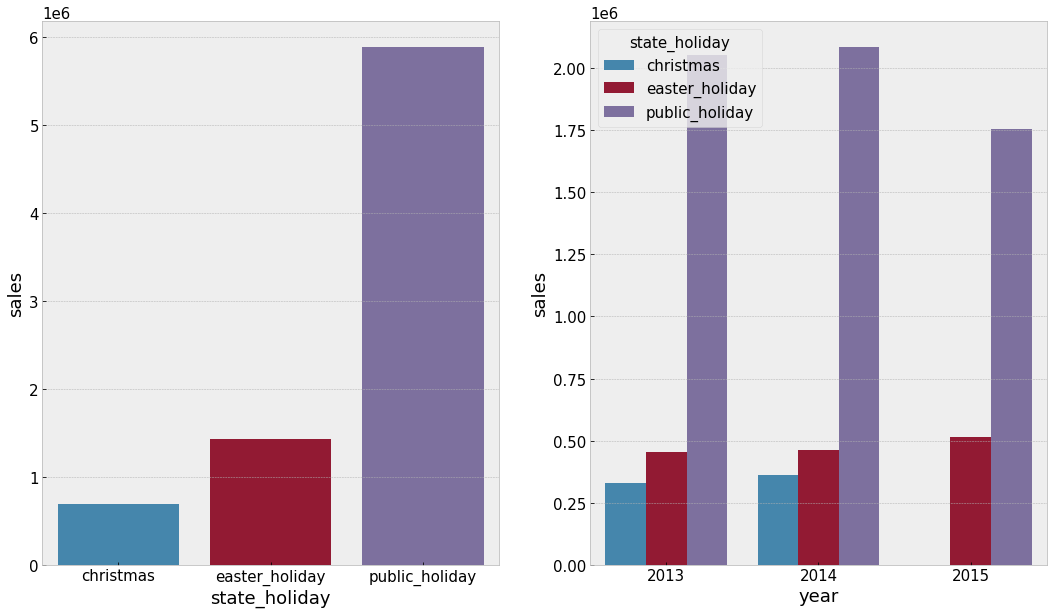

In [68]:
aux = df3[df3['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2)

### H8.Lojas deveriam vender mais ao longo dos anos
**Falsa** Lojas vendem menos ao longo dos anos

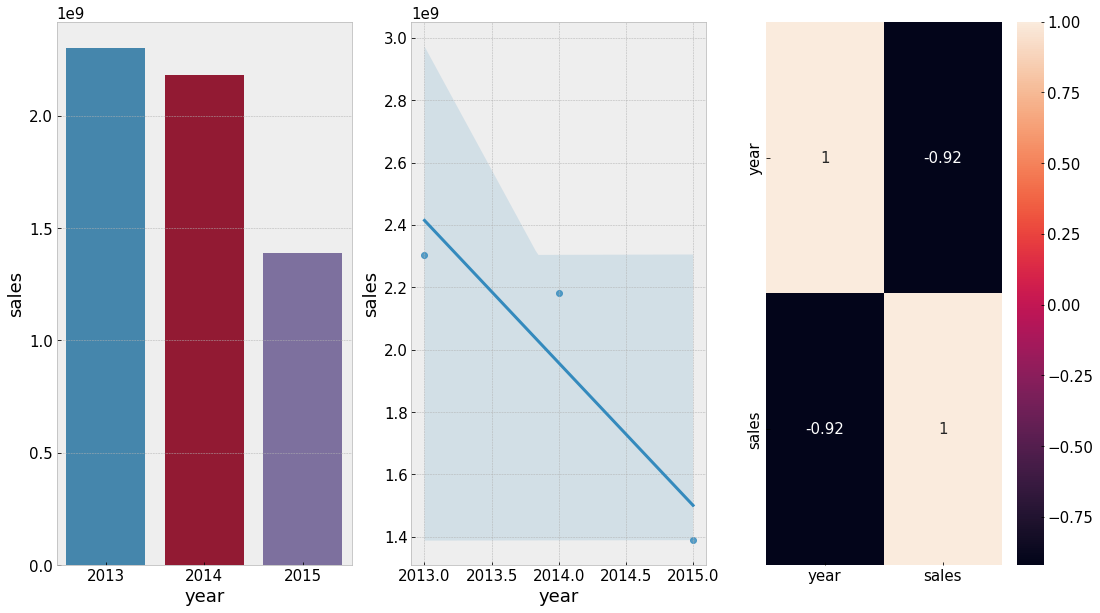

In [74]:
aux1 = df3[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano
**Falsa** Lojas vendme menos no segundo semestre do ano 

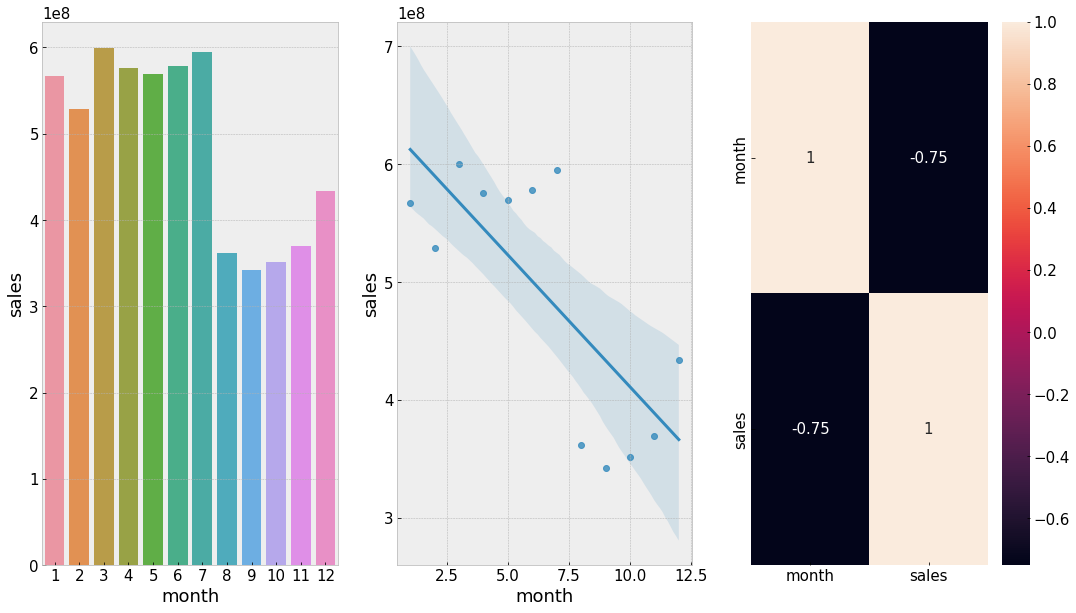

In [76]:
aux1 = df3[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10.Lojas deveriam vender mais depois do dia 10 do mês
**Verdadeira** As lojas vendem mais depois do dia 10 de cada mês

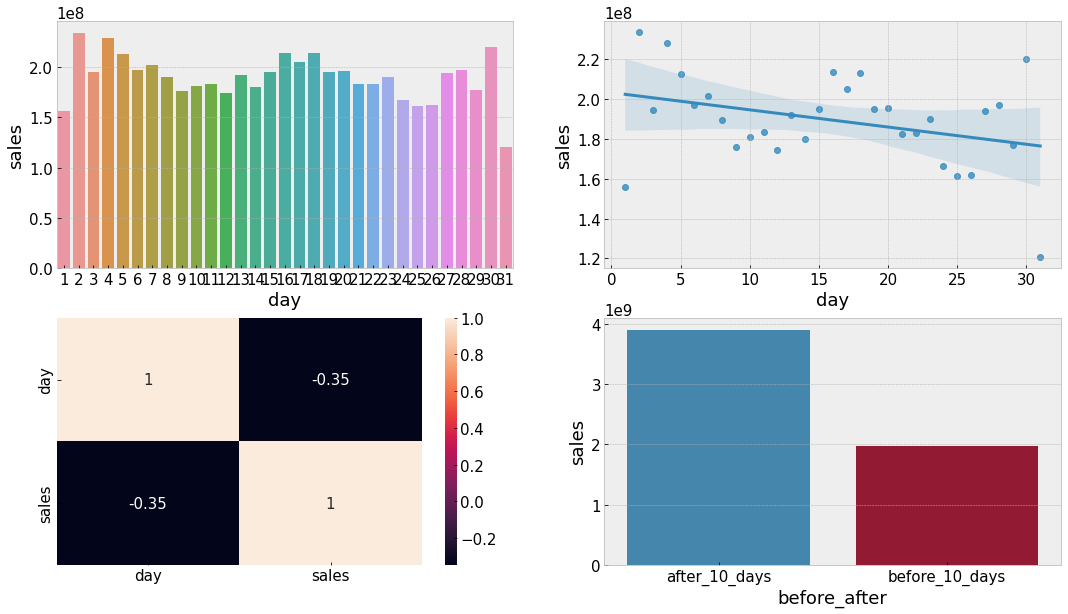

In [80]:
aux1 = df3[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 2 )
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot( 2, 2, 4 )
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### H11.Lojas deveriam vender menos aos finais de semana
**Verdadeira** Lojas vendem menos no final de semana

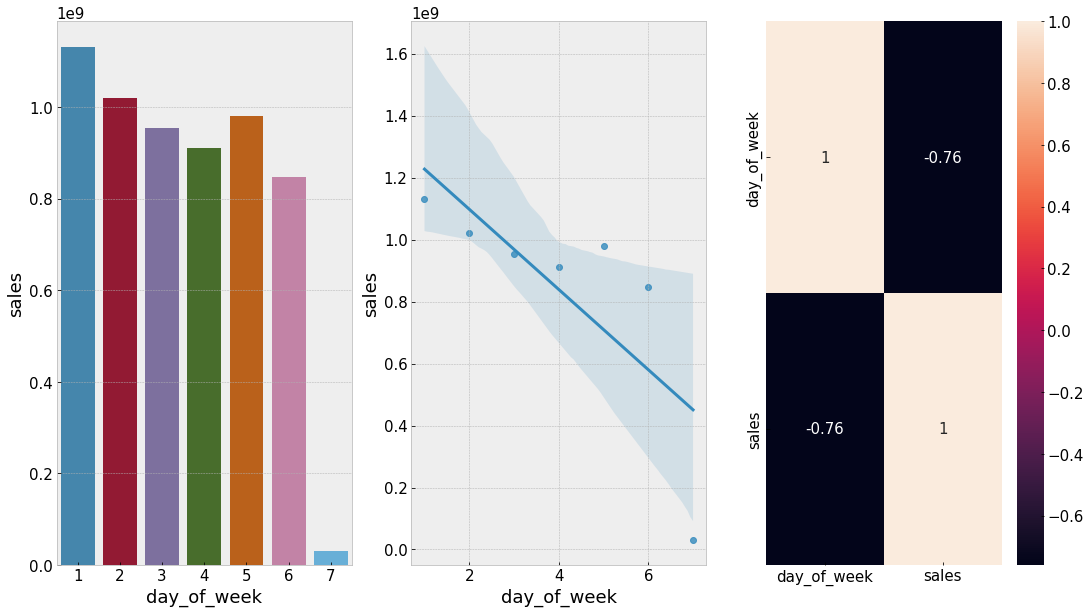

In [83]:
aux1 = df3[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12.Lojas deveriam vender menos durante os feriados escolares  
**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto em Julho e Agosto

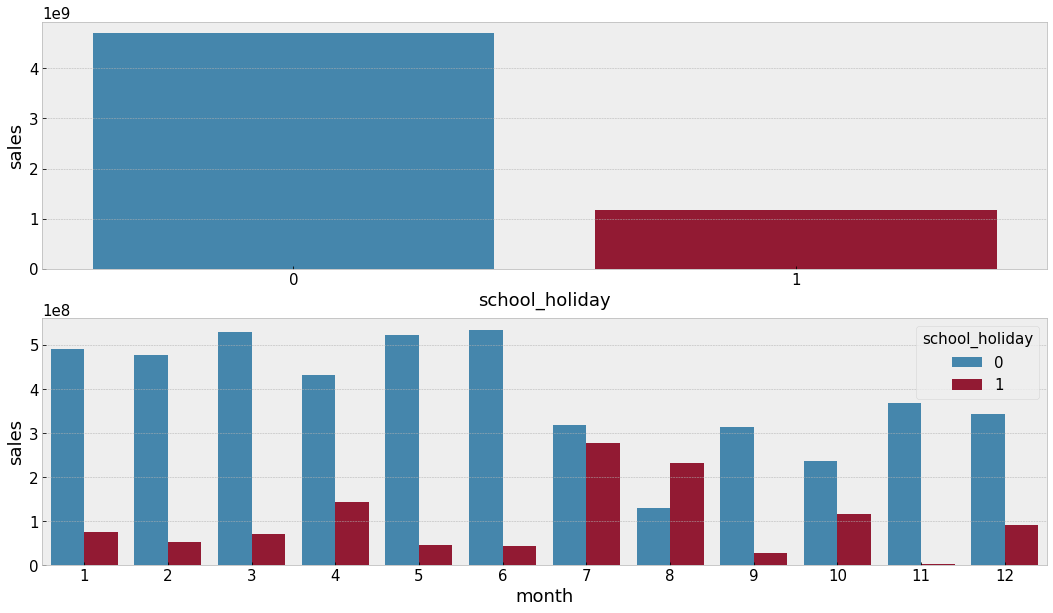

In [86]:
aux1 = df3[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot( x='school_holiday', y='sales', data=aux1);

aux2 = df3[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2);

### Resumo das Hipótesis

In [90]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-----', '-----'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]
print( tabulate( tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -----        -----
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

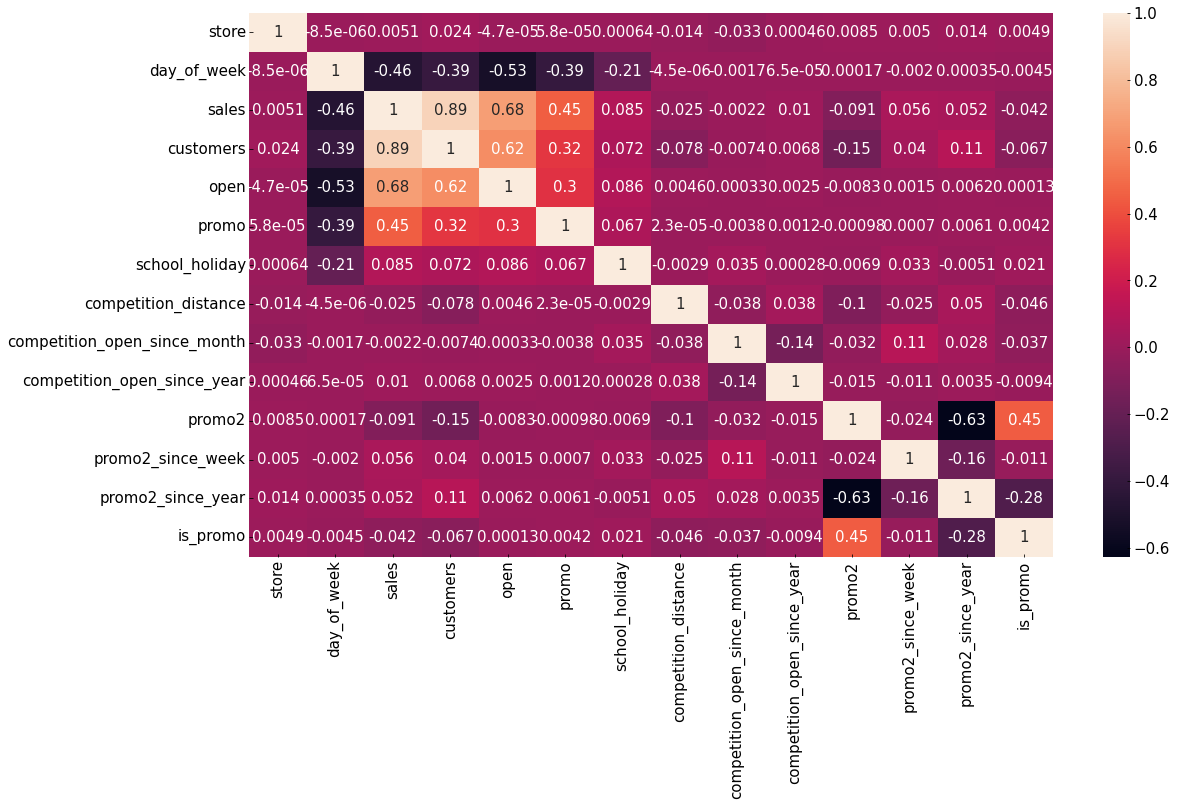

In [92]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap(correlation, annot=True);

### 4.3.1 Numerical Attributes

In [103]:
df3['competition_since'] = pd.to_datetime( df3['competition_since'])
df3['promo_since'] = pd.to_datetime( df3['promo_since'])

In [104]:
# 

<AxesSubplot:>

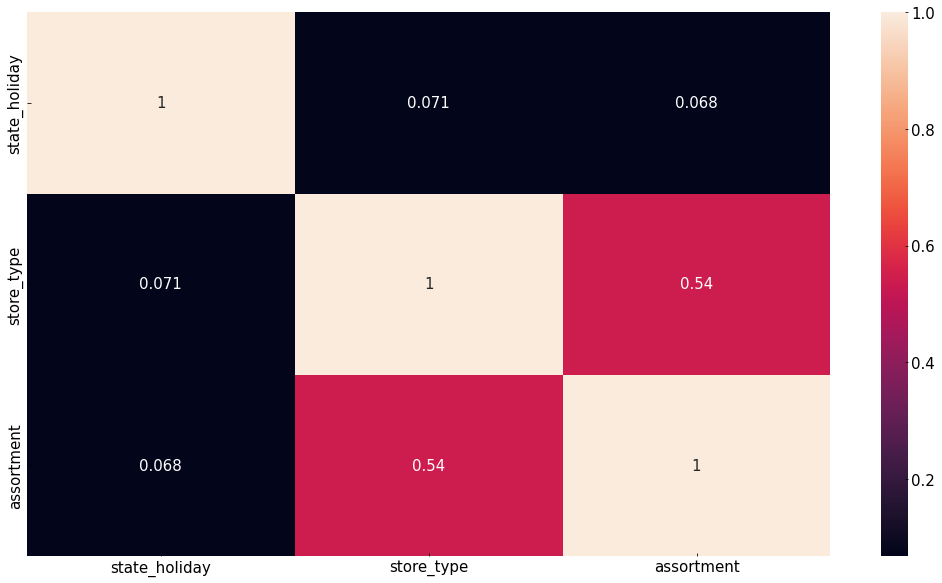

In [134]:
# Only categorical data
a = df3.select_dtypes( include= 'object' )

# Calculated cramer_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type':    [a4, a5, a6],
               'assortment':    [a7, a8, a9]
              })

d = d.set_index( d.columns )

sns.heatmap(d, annot=True)

# 5.0 Preparação dos Dados

In [135]:
#df3.to_csv('df3.csv', index_label=False )

In [136]:
df4 = pd.read_csv( 'df3.csv', low_memory=False )

## 5.1 Normalização

Na seção 4.1.2 Numerical Variable, não há nada que possa ser normalizado

## 5.2 Rescaling

In [149]:
rs = RobustScaler()
mms= MinMaxScaler()

# competition distance
df4['competition_distance'] = rs.fit_transform(df4[['competition_distance']].values)

# year
df4['year'] = mms.fit_transform(df4[['year']].values)

# competition time month
df4['competition_time_month'] = rs.fit_transform(df4[['competition_time_month']].values)

#promo time week
df4['promo_time_week'] = mms.fit_transform(df4[['promo_time_week']].values)


## 5.1 Transformação

In [ ]:
# month
# day
# week of year
# day of week